## 1. Importing Libraries

In [1]:
from pathlib import Path
import imghdr
import os
from collections import defaultdict

import os
import imghdr
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

import cv2

In [2]:
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
keras.utils.set_random_seed(seed_value)

## 2. Loading dataset

#### Duplicating the dataset to allow multiple runs

In [3]:
import shutil
import os

# Define the original and duplicate folder paths
original_folder = "hair_types"
duplicate_folder = "hair_types_copy"

# Check if the duplicate folder exists, and delete it if it does
if os.path.exists(duplicate_folder):
    shutil.rmtree(duplicate_folder)

# Create a duplicate of the entire folder
shutil.copytree(original_folder, duplicate_folder)

print("Duplicate folder created successfully!")


Duplicate folder created successfully!


#### 2.1 Specifying and Counting Accepted File types

In [4]:
data_dir = "hair_types_copy"

image_extensions = [".png", ".jpg" , ".jpeg",] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

In [5]:
file_types_count = defaultdict(int)

for filepath in Path(data_dir).rglob("*"):
    file_extension = filepath.suffix.lower()
    file_types_count[file_extension] += 1

print("File types present in the directory:")
for file_type, count in file_types_count.items():
    print(f"{file_type}: {count} files")

File types present in the directory:
: 3 files
.jpg: 882 files
.png: 23 files
.jpeg: 82 files
.gif: 1 files


#### 2.2 Counting Images per Class

In [6]:
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"Folder '{class_name}' : {count} images.")
    
total_count = sum(class_counts.values())
print("Total count:", total_count)

Folder 'Curly_Hair' : 339 images.
Folder 'Straight_Hair' : 318 images.
Folder 'Wavy_Hair' : 331 images.
Total count: 988


#### 2.3 Filters the images based on accepted files

In [7]:
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type == "webp":
            # Convert WebP image to JPEG
            img = Image.open(filepath)
            jpeg_path = filepath.with_suffix(".jpg")
            img.convert("RGB").save(jpeg_path)
            img.close()
            os.remove(filepath) 
        elif img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

#### 2.4 Checking the Classes

In [8]:
data = tf.keras.utils.image_dataset_from_directory('hair_types_copy')

Found 988 files belonging to 3 classes.


In [9]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

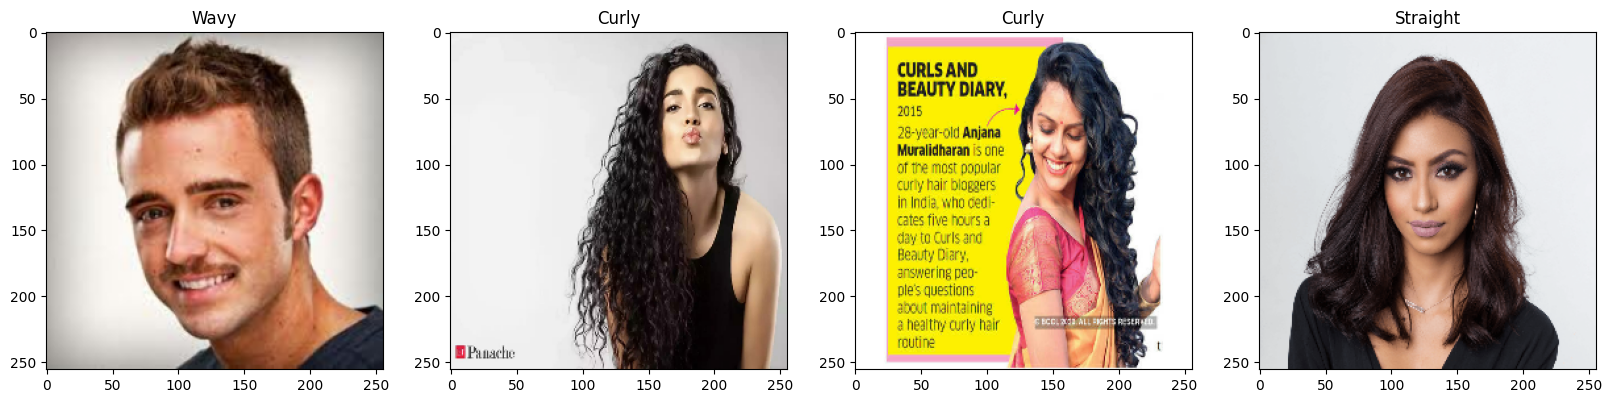

In [10]:
class_names = {0: "Curly", 1: "Straight", 2: "Wavy"}

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    label = batch[1][idx]
    class_name = class_names.get(label, "Unknown") 
    ax[idx].title.set_text(class_name)

plt.show()

#### 2.5 Image Resizing


In [11]:
image_size = (224, 224)
batch_size = 32

In [12]:
resized_count = 0
not_resized_count = 0
not_resized_files = []

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        try:
            with Image.open(filepath) as img:
                img_resized = img.resize((224, 224))
                img_resized.save(filepath)
                resized_count += 1
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
            not_resized_count += 1
            not_resized_files.append(filepath)
            os.remove(filepath)

print(f"Resized images: {resized_count}")
print(f"Not resized images: {not_resized_count}")

if not_resized_files:
    print("Files not resized:")
    for file in not_resized_files:
        print(file)
        os.remove(filepath)


Error processing hair_types_copy\Straight_Hair\01-10-2019-latest-haircut-for-girls_short_pixie_straight_undercut_3PNG.jpg: cannot write mode RGBA as JPEG
Resized images: 986
Not resized images: 1
Files not resized:
hair_types_copy\Straight_Hair\01-10-2019-latest-haircut-for-girls_short_pixie_straight_undercut_3PNG.jpg


#### 2.6 Applying Histogram Equalization - Greyscale - Gaussian Blur - Sobel Edge Detection to the images

Ignoring non-image file: hair_types_copy\Curly_Hair
Ignoring non-image file: hair_types_copy\Straight_Hair
Ignoring non-image file: hair_types_copy\Wavy_Hair
Error converting hair_types_copy\Curly_Hair\CurlyHair-Productsin-India.png: not supported for mode RGBA
Error converting hair_types_copy\Curly_Hair\screen-shot-2020-03-24-at-11-23-46-am-1585063518.png: not supported for mode RGBA
Error converting hair_types_copy\Curly_Hair\SHAMPOOS-1.png: not supported for mode RGBA
Error converting hair_types_copy\Straight_Hair\77a88adbd375ca09e63bffb22a12ee6f.png: not supported for mode RGBA
Error converting hair_types_copy\Straight_Hair\831eb082edfd8e16d0d63be8bfa4946c.png: not supported for mode RGBA
Error converting hair_types_copy\Straight_Hair\9e124569d58a4c6451f50d65db5b1198.png: not supported for mode RGBA
Error converting hair_types_copy\Straight_Hair\hair-straightener-e1557734929928-1280x720.png: not supported for mode RGBA
Error converting hair_types_copy\Straight_Hair\haircuts-for-rou

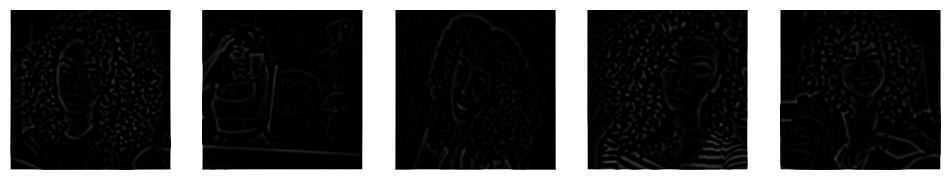

In [13]:
import numpy as np
from PIL import Image, ImageOps, ImageFilter
from pathlib import Path
import matplotlib.pyplot as plt

sample_images = []
num_converted = 0

for filepath in Path(data_dir).rglob("*"):
    # Check if the file is an image file
    if filepath.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
        try:
            # Open the image file
            img = Image.open(filepath)

            # Histogram Equalization
            img = ImageOps.equalize(img)

            # Convert the image to grayscale
            img_gray = img.convert('L')

            # Apply Gaussian blur
            img_blur = img_gray.filter(ImageFilter.GaussianBlur(2))

            # Sobel Edge Detection
            img_edge = img_blur.filter(ImageFilter.FIND_EDGES)

            # Save the edge-detected image, overwriting the original
            img_edge.save(filepath)

            # Increment the count of converted images
            num_converted += 1

            # Add converted image to sample list
            sample_images.append(img_edge)

        except Exception as e:
            print(f"Error converting {filepath}: {e}")
            # Optionally, remove the file if conversion fails
            os.remove(filepath)
    else:
        print(f"Ignoring non-image file: {filepath}")

# Display the number of converted images
print(f"Number of converted images: {num_converted}")

# Display some sample images
num_samples = min(5, len(sample_images))  # Display up to 5 samples
fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

for i in range(num_samples):
    axes[i].imshow(sample_images[i], cmap='gray')
    axes[i].axis('off')

plt.show()


## 3. Data Splitting

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types_copy/",                         
    validation_split=0.2,                  
    subset="training",                     
    seed=seed_value,                            
    image_size=image_size,                 
    batch_size=batch_size,                
    labels='inferred',                     
    label_mode='categorical'             
)

Found 973 files belonging to 3 classes.
Using 779 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types_copy/",                        
    validation_split=0.2,                  
    subset="validation",                  
    seed=seed_value,                       
    image_size=image_size,                 
    batch_size=batch_size,          
    labels='inferred',  
    label_mode='categorical'              
)

Found 973 files belonging to 3 classes.
Using 194 files for validation.


## 4. Visualizing the Data

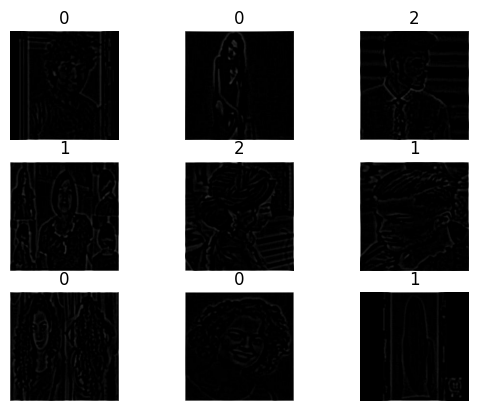

In [16]:
# Iterate over the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Display the first 9 images in a 3x3 grid
    for i in range(9):
        # Create a subplot for each image
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image as a numpy array and convert it to uint8 datatype
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Set the title of the subplot to the integer label of the image
        plt.title(int(np.argmax(labels[i])))
        
        # Disable axis ticks and labels
        plt.axis("off")
# Display the plot
plt.show()

## 5. Creating the CNN Model

In [17]:
# Create a Sequential model
model = Sequential()

# Add an input layer with the specified image size and 3 color channels
model.add(keras.Input(shape=image_size + (3,)))  # 224x224x1

# Normalize pixel values to the range [0, 1]
model.add(layers.Rescaling(1.0 / 255))

In [18]:
from keras.layers import BatchNormalization #new

# Add convolutional layers with ReLU activation
model.add(layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(padding='same'))

model.add(layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(padding='same'))

model.add(layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(padding='same'))

model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(padding='same'))

model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(padding='same'))


In [19]:
# Add global average pooling layer
model.add(layers.GlobalAveragePooling2D())

In [20]:
model.add(layers.Flatten())

In [21]:
# Add fully connected layers with ReLU activation
model.add(layers.Dense(128))
model.add(layers.Activation("relu"))

In [22]:
# Add output layer with softmax activation for multi-class classification
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

In [23]:
# Set the number of training epochs or iterations
epochs = 50

In [24]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 4)       112       
                                                                 
 activation (Activation)     (None, 224, 224, 4)       0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 4)      16        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       2

In [26]:
# Train the model on the training dataset, and validate on the validation dataset
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/50
25/25 [==============================] - 6s 62ms/step - loss: 1.0979 - accuracy: 0.3646 - val_loss: 1.0985 - val_accuracy: 0.3505
Epoch 2/50
25/25 [==============================] - 1s 32ms/step - loss: 1.0838 - accuracy: 0.3902 - val_loss: 1.0992 - val_accuracy: 0.3505
Epoch 3/50
25/25 [==============================] - 1s 30ms/step - loss: 1.0673 - accuracy: 0.4275 - val_loss: 1.1026 - val_accuracy: 0.3505
Epoch 4/50
25/25 [==============================] - 1s 30ms/step - loss: 1.0348 - accuracy: 0.4660 - val_loss: 1.1288 - val_accuracy: 0.3402
Epoch 5/50
25/25 [==============================] - 1s 33ms/step - loss: 1.0641 - accuracy: 0.4211 - val_loss: 1.1141 - val_accuracy: 0.3144
Epoch 6/50
25/25 [==============================] - 1s 29ms/step - loss: 0.9996 - accuracy: 0.4711 - val_loss: 1.2054 - val_accuracy: 0.3144
Epoch 7/50
25/25 [==============================] - 1s 31ms/step - loss: 0.9644 - accuracy: 0.4775 - val_loss: 1.4328 - val_accuracy: 0.3144
Epoch 8/50
25

### 6. Plotting Model Performance

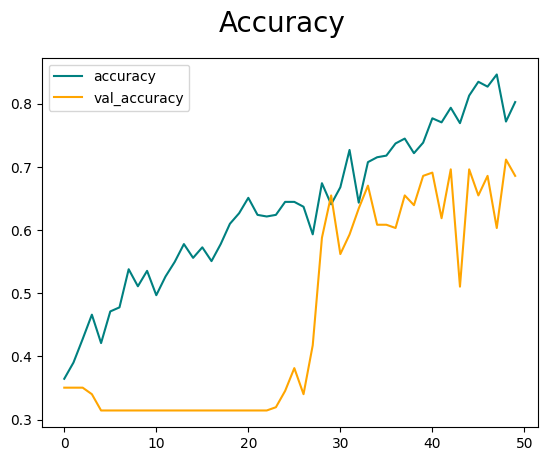

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

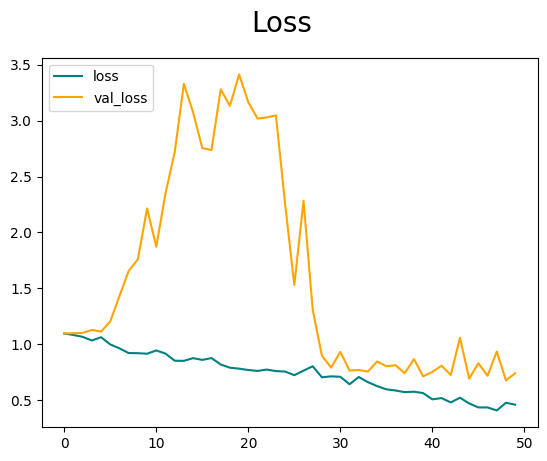

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 7. Model Prediction

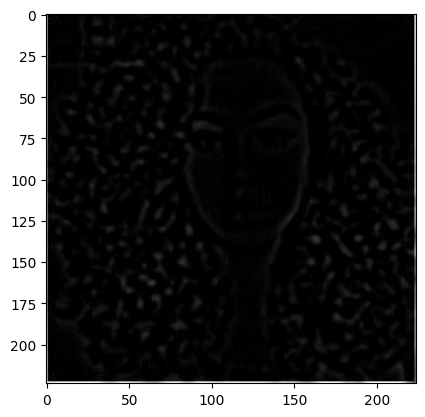

This image is 0.99 percent curly hair, 0.00 percent straight hair, and 0.00 percent wavy hair.
Predicted Image Class: Curly Hair
Actual Image Class: Curly_Hair


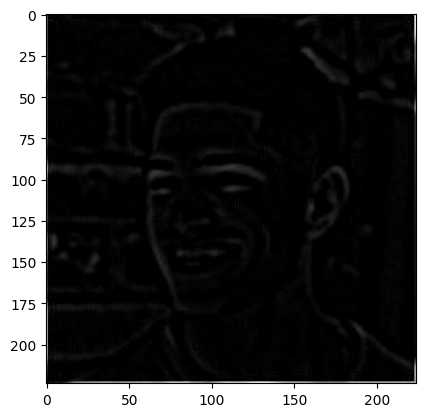

This image is 0.00 percent curly hair, 0.97 percent straight hair, and 0.02 percent wavy hair.
Predicted Image Class: Straight Hair
Actual Image Class: Straight_Hair


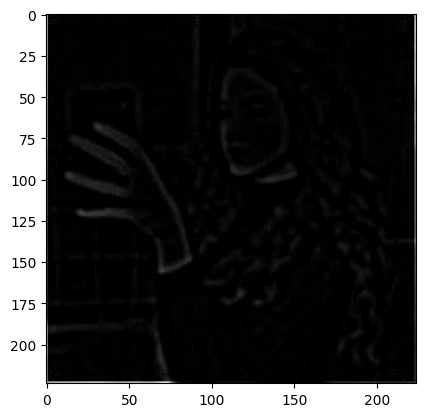

This image is 0.09 percent curly hair, 0.10 percent straight hair, and 0.80 percent wavy hair.
Predicted Image Class: Wavy Hair
Actual Image Class: Wavy_Hair


In [30]:
import random  # Import the random module

# Function to load and predict images
def predict_image(image_path):
    # Load an image from the specified file path, resizing it to the target size
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)

    # Convert the loaded image to a NumPy array
    img_array = keras.preprocessing.image.img_to_array(img)

    # Add a batch axis to the image array to create a batch of size 1
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    # Use the trained model to make predictions on the image array
    predictions = model.predict(img_array)

    # Print the image
    plt.imshow(img)
    plt.show()

    # Print the predicted probabilities for each hair type
    print(
        "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
        % tuple(predictions[0])
    )

    # Find the index of the maximum probability
    predicted_class_index = np.argmax(predictions[0])

    # Define the class labels
    class_labels = ["Curly Hair", "Straight Hair", "Wavy Hair"]

    # Print the predicted image class
    predicted_class = class_labels[predicted_class_index]
    print("Predicted Image Class:", predicted_class)

    # Get the actual class name from the image path
    actual_class = os.path.basename(os.path.dirname(image_path))
    print("Actual Image Class:", actual_class)

# Path to the folders containing images
folder_paths = ["hair_types_copy/Curly_Hair/", "hair_types_copy/Straight_Hair/", "hair_types_copy/Wavy_Hair/"]

# Loop through each folder
for folder_path in folder_paths:
    # Get a list of image file names in the folder
    image_files = os.listdir(folder_path)
    
    # Select a random image from the folder
    random_image = random.choice(image_files)
    
    # Construct the full path to the random image
    image_path = os.path.join(folder_path, random_image)
        
    # Predict the image and display the results
    predict_image(image_path)